In [84]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os,cv2
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

In [2]:
df="/kaggle/input/clouds-gan-dataset/clouds"

In [7]:
datagen=ImageDataGenerator(
rotation_range=42,
rescale=1.0/255,
horizontal_flip=True,
shear_range=0.2,
zoom_range=0.2,
width_shift_range=0.2,
height_shift_range=0.2,
fill_mode="nearest"
)

In [11]:
train_data=datagen.flow_from_directory(
df,
target_size=(256,256),
batch_size=32,
class_mode=None)

Found 0 images belonging to 0 classes.


In [22]:
new_img=[]
for file in os.listdir(df):
    data=os.path.join(df,file)
    cv=cv2.imread(data)
    cv_resize=cv2.resize(cv,(256,256))
    new_img.append(cv_resize)
new_img=np.array(new_img)

# # GAN

In [26]:
from keras.layers import Dense,Flatten,Conv2D,Conv2DTranspose,Input
import numpy as np
from keras.models import Model


In [48]:
dataset = image_dataset_from_directory(
    df,
    labels=None,  # For GAN, no labels are needed
    batch_size=32,
    image_size=(256, 256),  # Image size expected by your model
    shuffle=True
)

Found 1628 files.


In [80]:
def build_gan():
    inputs = Input(shape=(256, 256, 3))
    C = Conv2D(32, (3, 3), activation="relu", padding='same')(inputs)
    outputs = Conv2D(3, (3, 3), activation="softmax", padding="same")(C)
    model = Model(inputs, outputs)
    return model

def build_dis():
    inputs = Input(shape=(256, 256, 3))
    C = Conv2D(32, (3, 3), activation="relu", padding='same')(inputs)
    C = Flatten()(C)
    outputs = Dense(1, activation="sigmoid")(C)  
    model = Model(inputs, outputs)
    return model

def train_model(gan, dis, epochs, batch_size, dataset):
    dis.trainable = True
    dis.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  

    for epoch in range(epochs):
        for real_img in dataset:
            noise = np.random.normal(0,1,(batch_size, 256, 256, 3))
            fake_img = gan.predict(noise)
            fake_label = np.zeros((batch_size, 1))
        
#             real_img = [img for img in dataset]
            real_label = np.ones((batch_size, 1)) 
            real_img = real_img[:batch_size,:]

            if real_img.shape[-1] != 3: 
                real_img = np.expand_dims(real_img, axis=-1)
                dis.trainable = True
                dis.train_on_batch(real_img, real_label) 
                dis.train_on_batch(fake_img, fake_label)  

                dis.trainable = False
                gan.train_on_batch(noise, real_label)  

    return gan


generator = build_gan()
discriminator = build_dis()
train_gen=train_model(generator, discriminator, epochs=3, batch_size=32, dataset=dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [88]:
new_img[0].shape

(256, 256, 3)

In [92]:
img = new_img[0] 
img = img.astype('float32') / 255.0  
img = np.expand_dims(img, axis=0) 

d=train_gen.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


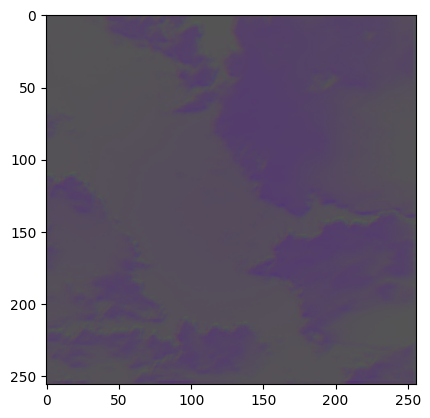

In [95]:
image_to_show = (d[0]* 255).astype(np.uint8)

plt.imshow(image_to_show)
plt.show()